In [1]:
!pip install -r requirements.txt
import pandas as pd

df = pd.read_csv('content.csv')


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from rake_nltk import Rake
from msticpy.data import data_obfus

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gr8monk3ys/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gr8monk3ys/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df.head()

,Unnamed: 0,title,author,timestamp
0,0,Another step closer to ruining the internet fo...,creggor,2024-02-13T21:40:30.886000+0000
1,1,Chinese researchers develop calcium-based batt...,chrisdh79,2024-02-13T12:04:27.407000+0000
2,2,Replacement cartilage can grow in any shape wi...,chrisdh79,2024-02-13T21:07:53.955000+0000
3,3,OpenAI CEO warns that 'societal misalignments'...,JackFisherBooks,2024-02-13T20:21:39.876000+0000
4,4,"28-ton, 1.2-megawatt tidal kite is now exporti...",chrisdh79,2024-02-12T13:05:41.010000+0000


In [4]:
def process(raw_df):
    '''
    Wendy & Lorenzo's part
    input: the dataframe returned by the scrape() function
    output: the processed dataframe that is about to be stored in db
    '''
    processed_df = raw_df.drop_duplicates()
    #processed_df['timestamp'] = pd.to_datetime(processed_df['timestamp'], unit='s')
    #processed_df['domain'] = processed_df['title'].str.extract(r'\((.*?)\)')
    #processed_df.drop(columns=['title'], inplace=True)
    #processed_df.rename(columns={'author': 'post_author', 'timestamp': 'post_timestamp'}, inplace=True)

    keyword_list = []
    for item in processed_df['title']:
        rake = Rake() # create rake object
        rake.extract_keywords_from_text(item) 
        score_phrase_pair = rake.get_ranked_phrases_with_scores() # return key phrases and its scores 
        # limit phrases with score that is 4 and up
        phrase_with_scores_five_and_up = [phrase for score, phrase in score_phrase_pair if score>=4]
        # limit topic phrases to 5
        phrase_with_scores_five_and_up = phrase_with_scores_five_and_up[:5]
        keyword_list.append(phrase_with_scores_five_and_up)

    processed_df['keywords'] = keyword_list
    
    # turn the list into string so that it can be stored in db
    processed_df['keywords'] = processed_df['keywords'].apply(lambda x: ','.join(map(str, x)))
    masked_user = []
    for username in processed_df['author']:
        masked_user.append(data_obfus.hash_account(username))

    processed_df['masked user'] = masked_user

    return processed_df

In [5]:
processed_df = process(df)
processed_df.head()

,Unnamed: 0,title,author,timestamp,keywords,masked user
0,0,Another step closer to ruining the internet fo...,creggor,2024-02-13T21:40:30.886000+0000,another step closer,account-#11468
1,1,Chinese researchers develop calcium-based batt...,chrisdh79,2024-02-13T12:04:27.407000+0000,"chinese researchers develop calcium,lasts 700 ...",account-#13984
2,2,Replacement cartilage can grow in any shape wi...,chrisdh79,2024-02-13T21:07:53.955000+0000,replacement cartilage,account-#13984
3,3,OpenAI CEO warns that 'societal misalignments'...,JackFisherBooks,2024-02-13T20:21:39.876000+0000,"could make artificial intelligence dangerous,o...",account-#16919
4,4,"28-ton, 1.2-megawatt tidal kite is now exporti...",chrisdh79,2024-02-12T13:05:41.010000+0000,"megawatt tidal kite,exporting power",account-#13984


In [6]:
list_of_keywords = processed_df['keywords'].apply(lambda x: x.split(','))

In [7]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import string
from nltk.tokenize import word_tokenize

In [8]:
# distributed memory
model_dm = Doc2Vec(dm=1, vector_size=25, min_count=2, epochs=30)

In [9]:
title_text = [x.translate(str.maketrans('', '', string.punctuation)) for x in processed_df['title'] if True]
# remove punctuation

In [10]:
title_text_lower = [x.lower() for x in title_text] # make all words lowercased

In [11]:
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()),
                              tags=[str(i)]) for i, doc in enumerate(title_text_lower)]

In [12]:
model_dm.build_vocab(tagged_data)

In [13]:
model_dm.train(tagged_data,
            total_examples=model_dm.corpus_count,
            epochs=model_dm.epochs)

In [14]:
document_vectors = [model_dm.infer_vector(word_tokenize(doc.lower())) for doc in title_text_lower]

In [15]:
text_vec_df = pd.DataFrame({'title': processed_df['title'], 
                            'keywords':list_of_keywords, 'vectors': document_vectors})

In [16]:
text_vec_df.head()

,title,keywords,vectors
0,Another step closer to ruining the internet fo...,[another step closer],"[-0.039587952, -0.15850519, -0.00421843, -0.17..."
1,Chinese researchers develop calcium-based batt...,"[chinese researchers develop calcium, lasts 70...","[-0.07996254, -0.3546335, 0.008176135, -0.4071..."
2,Replacement cartilage can grow in any shape wi...,[replacement cartilage],"[-0.022214476, -0.106620535, -0.008853883, -0...."
3,OpenAI CEO warns that 'societal misalignments'...,"[could make artificial intelligence dangerous,...","[-0.06288702, -0.19826362, -0.022574266, -0.21..."
4,"28-ton, 1.2-megawatt tidal kite is now exporti...","[megawatt tidal kite, exporting power]","[-0.020205967, -0.090211995, 0.0039719567, -0...."


In [17]:
def document_vector(df):
    '''
    input df produced by the process function (pulled from db version)
    returns a df with 3 columns: reddit post title, list of keyword extracted from title, and document vector corresponding to title
    '''
    # remove punctuations
    title_text = [x.translate(str.maketrans('', '', string.punctuation)) for x in df['title'] if True]
    # lowercase all characters
    title_text_lower = [x.lower() for x in title_text]
    
    # distributed memory
    model_dm = Doc2Vec(dm=1, vector_size=25, min_count=2, epochs=30)
    tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()),
                              tags=[str(i)]) for i, doc in enumerate(title_text_lower)]
    model_dm.build_vocab(tagged_data)
    model_dm.train(tagged_data,
            total_examples=model_dm.corpus_count,
            epochs=model_dm.epochs)
    
    document_vectors = [model_dm.infer_vector(word_tokenize(doc.lower())) for doc in title_text_lower]
    
    text_vec_df = pd.DataFrame({'title': df['title'], 
                            'keywords':list_of_keywords, 'vectors': document_vectors})
    return text_vec_df

In [18]:
vector_df = document_vector(processed_df)
vector_df.head()

,title,keywords,vectors
0,Another step closer to ruining the internet fo...,[another step closer],"[-0.039587952, -0.15850519, -0.00421843, -0.17..."
1,Chinese researchers develop calcium-based batt...,"[chinese researchers develop calcium, lasts 70...","[-0.07996254, -0.3546335, 0.008176135, -0.4071..."
2,Replacement cartilage can grow in any shape wi...,[replacement cartilage],"[-0.022214476, -0.106620535, -0.008853883, -0...."
3,OpenAI CEO warns that 'societal misalignments'...,"[could make artificial intelligence dangerous,...","[-0.06288702, -0.19826362, -0.022574266, -0.21..."
4,"28-ton, 1.2-megawatt tidal kite is now exporti...","[megawatt tidal kite, exporting power]","[-0.020205967, -0.090211995, 0.0039719567, -0...."


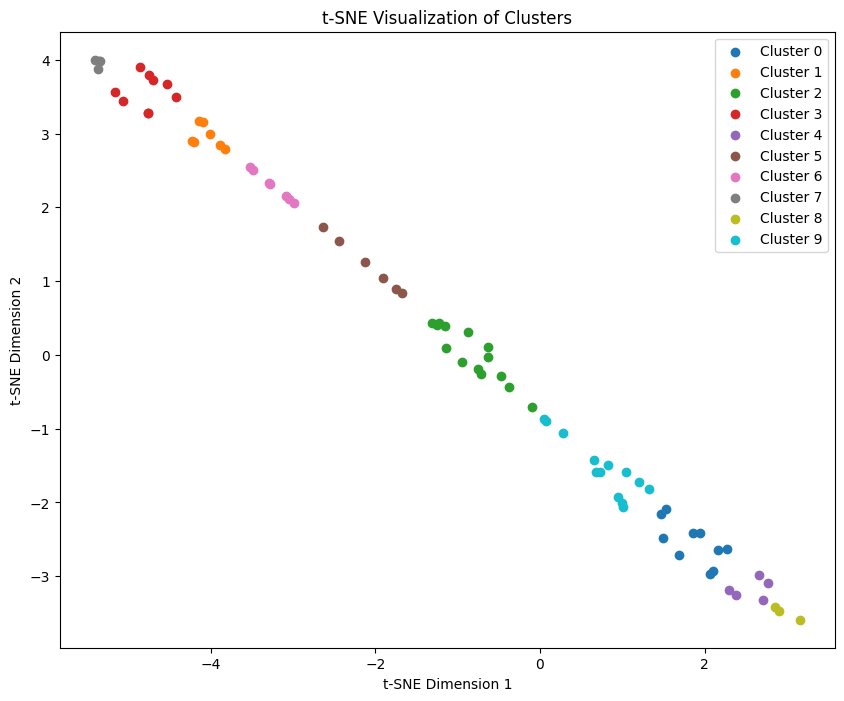

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def cluster_and_identify_keywords(vector_df):
    '''
    Cluster the messages based on the vector extracted from the text and identify keywords for each cluster.
    vector_df (DataFrame): A DataFrame with 3 columns: reddit post title, list of keywords extracted from title, and document vector corresponding to title.
    DataFrame: A DataFrame with 5 columns: reddit post title, list of keywords extracted from title, document vector corresponding to title, cluster label, and keywords associated with each cluster.
    '''
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(vector_df['keywords'].apply(lambda x: ' '.join(x)))
    
    kmeans = KMeans(n_clusters=10)
    kmeans.fit(vector_df['vectors'].to_list())  # Ensure 'vectors' is a list of arrays
    vector_df['cluster'] = kmeans.labels_
    
    cluster_keywords = {}
    feature_names = tfidf_vectorizer.get_feature_names_out()
    for cluster_label in range(kmeans.n_clusters):
        cluster_indices = vector_df[vector_df['cluster'] == cluster_label].index
        cluster_tfidf = tfidf_matrix[cluster_indices]
        cluster_keywords[cluster_label] = [feature_names[i] for i in cluster_tfidf.sum(axis=0).argsort()[-5:][::-1]]
    vector_df['cluster_keywords'] = vector_df['cluster'].map(cluster_keywords)
    return vector_df

clustered_df = cluster_and_identify_keywords(vector_df)
vectors_array = np.array(clustered_df['vectors'].to_list())

tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(vectors_array)

plt.figure(figsize=(10, 8))
for cluster_label in range(clustered_df['cluster'].nunique()):
    plt.scatter(vectors_2d[clustered_df['cluster'] == cluster_label, 0], 
                vectors_2d[clustered_df['cluster'] == cluster_label, 1], 
                label=f'Cluster {cluster_label}')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()
